In [0]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, LSTM, Embedding, SpatialDropout1D
from tensorflow.keras.layers import Attention
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
from IPython.display import HTML as html_print
from IPython.display import display
import keras.backend as K
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix, f1_score, precision_score, recall_score, plot_confusion_matrix
from google.colab import files
from pandas import DataFrame as df
import re
import os
import time
import numpy as np
import time
import string
import math
import matplotlib
import pickle

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
def create_model(input_dim, output_dim, lr, lr_decay, mom):
    model = Sequential()
    model.add(Dense(500, activation = 'relu', input_dim = input_dim))
    model.add(Dropout(0.1))
    model.add(Dense(300, activation = 'relu'))
    model.add(Dropout(0.1))
    model.add(Dense(250, activation = 'relu'))
    model.add(Dropout(0.1))
    model.add(Dense(output_dim, activation = 'sigmoid'))

    sgd = SGD(lr = lr, decay = lr_decay, momentum = mom)
    model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])

    return model

In [24]:
from google.colab import files
train_features = files.upload()
train_labels = files.upload()

Saving train_features_continuous.npy to train_features_continuous (1).npy


Saving train_labels_continuous.npy to train_labels_continuous (2).npy


In [0]:
X = np.load("train_features_continuous.npy")
X = np.delete(X, 0, axis = 1)
y = np.load("train_labels_continuous.npy")

In [18]:
print(X.shape)
print(y.shape)

(432, 7)
(432, 24)


In [0]:
lr = 0.0001
lr_decay = 1e-6
mom = 0.9
num_epochs = 600
batch_size = 36

In [28]:
feature_model = create_model(X.shape[1], y.shape[1], lr, lr_decay, mom)
feature_history = feature_model.fit(X, y, epochs = num_epochs, batch_size = batch_size)

Epoch 1/600
432/432 [==============================] - 0s 759us/step - loss: 0.4237 - accuracy: 0.8385
Epoch 2/600
432/432 [==============================] - 0s 178us/step - loss: 0.3104 - accuracy: 0.8727
Epoch 3/600
432/432 [==============================] - 0s 184us/step - loss: 0.3035 - accuracy: 0.8735
Epoch 4/600
432/432 [==============================] - 0s 179us/step - loss: 0.2979 - accuracy: 0.8753
Epoch 5/600
432/432 [==============================] - 0s 178us/step - loss: 0.2960 - accuracy: 0.8767
Epoch 6/600
432/432 [==============================] - 0s 220us/step - loss: 0.2909 - accuracy: 0.8781
Epoch 7/600
432/432 [==============================] - 0s 256us/step - loss: 0.2878 - accuracy: 0.8806
Epoch 8/600
432/432 [==============================] - 0s 179us/step - loss: 0.2861 - accuracy: 0.8806
Epoch 9/600
432/432 [==============================] - 0s 182us/step - loss: 0.2879 - accuracy: 0.8804
Epoch 10/600
432/432 [==============================] - 0s 196us/step - l

In [0]:
file_path = F"/content/gdrive/My Drive/model_600_mlp_continuous_36.h5" 

In [0]:
feature_model.save(file_path)

In [0]:
file_path = F"/content/gdrive/My Drive/model_600_mlp_continuous.h5" 
from keras.models import load_model
loaded_model = load_model(file_path)

In [7]:
genre_idx = files.upload()

Saving genre_idx.pickle to genre_idx.pickle


In [0]:
with open("genre_idx.pickle", "rb") as f:
  genre_idx = pickle.load(f)

In [0]:
preds = loaded_model.predict(X)
# preds[preds >= 0.25] = 1
# preds[preds < 0.25] = 0
genres = list(genre_idx.keys())
sorted_pred = [x for _,x in sorted(zip(preds[14],genres), reverse = True)]
print(sorted_pred)
correct_gen = []
for i in range(len(y[0])):
  if y[14][i] == 1:
    correct_gen.append(genres[i])
print(correct_gen)
print(preds[10])
print(preds[14])

['thriller', 'mystery', 'history', 'drama', 'crime', 'western', 'war', 'sport', 'short', 'scifi', 'romance', 'musical', 'music', 'horror', 'filmnoir', 'fantasy', 'family', 'documentary', 'comedy', 'biography', 'animation', 'adventure', 'adult', 'action']
['action', 'western']
[0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0.]
[0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0.]


In [108]:
load_preds = loaded_model.predict(X)
train_preds = load_preds
genres = list(genre_idx.keys())
num = 12
print(load_preds[num])

load_preds[load_preds >= 0.50] = 1
load_preds[load_preds < 0.50] = 0
print("Predict:", load_preds[num])
print("Answers:", y[num])

score = np.subtract(y[num], load_preds[num])
score = np.linalg.norm(score)
print("Score:", score)

predicted = []
correct_gen = []
for i in range(len(y[0])):
  if y[num][i] == 1:
    correct_gen.append(genres[i])
  if load_preds[num][i] == 1:
    predicted.append(genres[i])
print("Predict:", predicted)
print("Answers:", correct_gen)

sum_score = 0
num_wrong = 0
for i in range(len(load_preds)):
  score = np.subtract(y[i], load_preds[i])
  score = np.linalg.norm(score)
  if score != 0:
    num_wrong += 1
  sum_score += score
total_score = sum_score / len(load_preds)
print("Avg Score:", total_score)
print("Wrong:", num_wrong)

[1.69610594e-05 1.89513378e-16 5.05377930e-15 3.57493454e-34
 9.98679638e-01 7.77681407e-07 3.67969275e-04 3.86019258e-35
 9.99837995e-01 4.95895314e-26 1.12775624e-07 4.41841178e-35
 3.09473857e-23 3.87579203e-04 9.98735487e-01 5.39924763e-24
 2.45561232e-12 1.13699035e-13 1.36584211e-08 1.92727589e-33
 3.03081172e-36 1.04994955e-08 8.43213043e-23 1.18540136e-24]
Predict: [0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Answers: [0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Score: 0.0
Predict: ['biography', 'drama', 'music']
Answers: ['biography', 'drama', 'music']
Avg Score: 0.5032477869283318
Wrong: 166


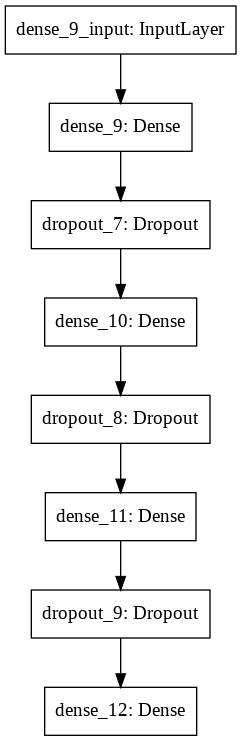

In [0]:
from keras.utils import plot_model
plot_model(feature_model, to_file='model.png')

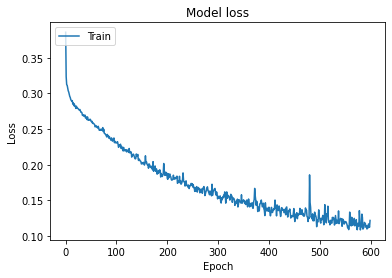

In [0]:
# Plot training & validation loss values
plt.plot(feature_history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

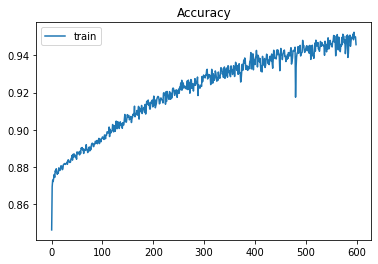

In [0]:
plt.title('Accuracy')
plt.plot(feature_history.history['accuracy'], label='train')
plt.legend()
plt.show()

In [114]:
confusion_mat = multilabel_confusion_matrix(y_test, test_preds)
print(confusion_mat.shape)
print(confusion_mat)
# plot_x = confusion_mat.transpose((0,1,2)).ravel()
# plot_y = confusion_mat.transpose((1,2,0)).ravel()
# plot_z = confusion_mat.transpose((2,0,1)).ravel()
# print(plot_x.shape)

(24, 2, 2)
[[[112  20]
  [ 44   9]]

 [[185   0]
  [  0   0]]

 [[146   0]
  [ 39   0]]

 [[179   0]
  [  6   0]]

 [[174   3]
  [  8   0]]

 [[136   0]
  [ 49   0]]

 [[ 78  79]
  [  7  21]]

 [[184   0]
  [  1   0]]

 [[  0  98]
  [  0  87]]

 [[181   0]
  [  4   0]]

 [[165   0]
  [ 20   0]]

 [[184   0]
  [  1   0]]

 [[175   2]
  [  8   0]]

 [[160   0]
  [ 25   0]]

 [[182   0]
  [  3   0]]

 [[184   0]
  [  1   0]]

 [[105  58]
  [ 14   8]]

 [[144   0]
  [ 41   0]]

 [[145   0]
  [ 40   0]]

 [[182   0]
  [  3   0]]

 [[183   0]
  [  2   0]]

 [[ 57  52]
  [ 27  49]]

 [[179   0]
  [  6   0]]

 [[159  21]
  [  3   2]]]


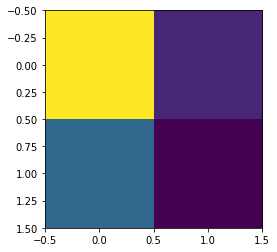

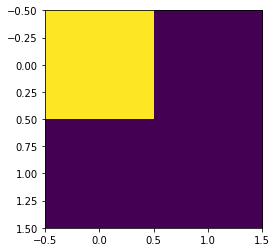

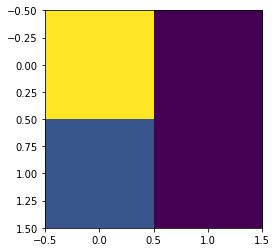

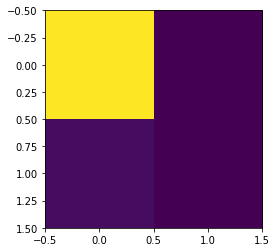

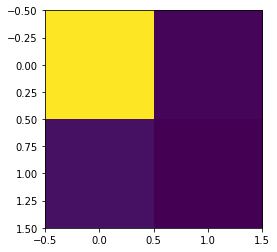

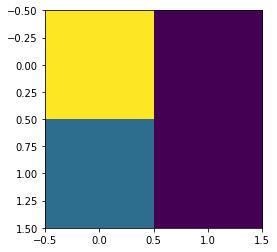

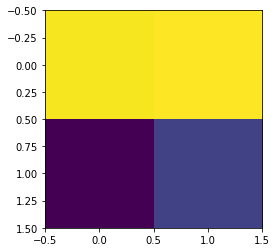

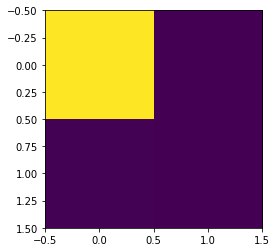

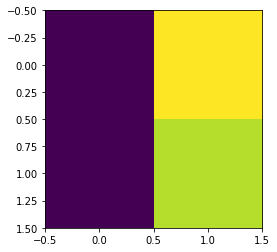

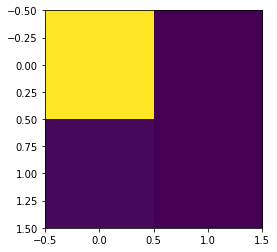

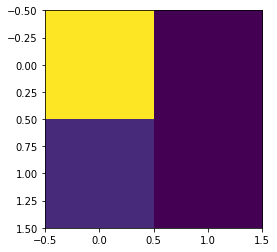

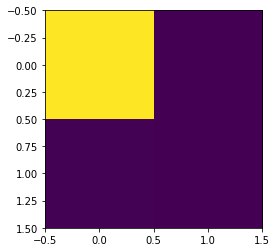

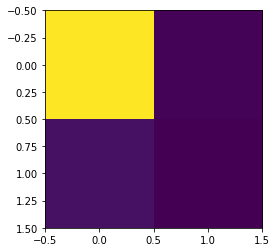

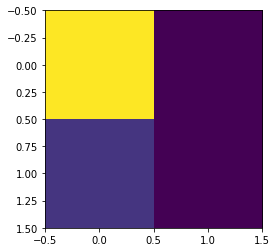

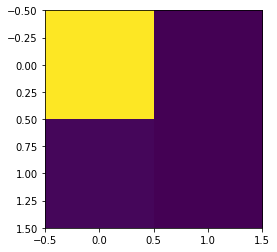

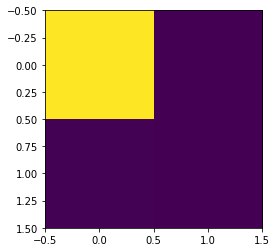

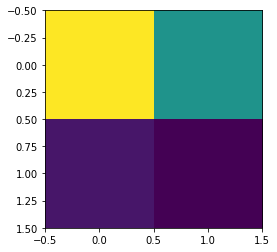

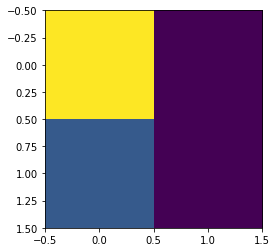

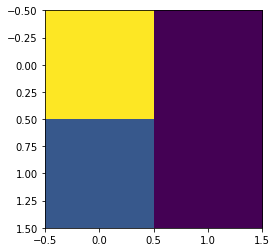

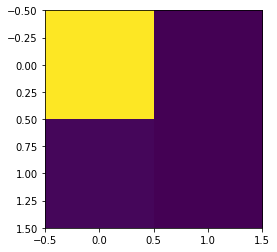

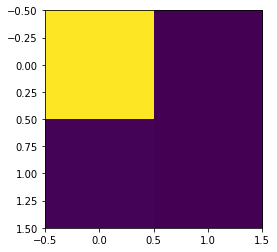

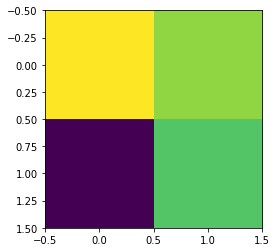

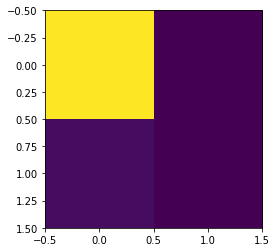

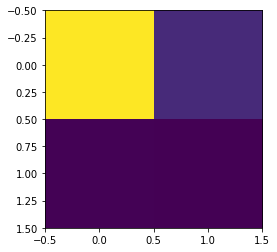

In [94]:
for mat in confusion_mat:
  plt.imshow(mat, cmap='viridis', interpolation='nearest')
  plt.show()

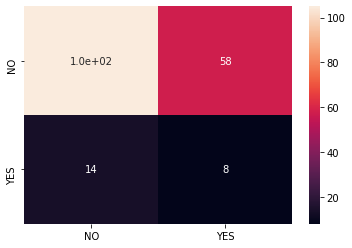

In [157]:
import seaborn as sn
mat = confusion_mat[16]
cm_df = df(mat, index = ['NO', 'YES'], columns = ['NO', 'YES'])
sn.heatmap(cm_df, annot = True)

{'action': 0, 'adult': 1, 'adventure': 2, 'animation': 3, 'biography': 4, 'comedy': 5, 'crime': 6, 'documentary': 7, 'drama': 8, 'family': 9, 'fantasy': 10, 'filmnoir': 11, 'history': 12, 'horror': 13, 'music': 14, 'musical': 15, 'mystery': 16, 'romance': 17, 'scifi': 18, 'short': 19, 'sport': 20, 'thriller': 21, 'war': 22, 'western': 23}
(52, 7)


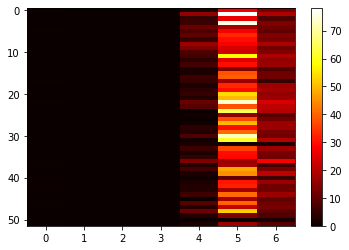

52


In [156]:
print(genre_idx)
num_gen = 0
vec = []
for i, p in enumerate(y_test):
  if p[21] == 0 and test_preds[i][21] == 1:
    num_gen += 1
    vec.append(np.array(X_test[i]))
    # vec = np.reshape(X_test[i], (1, 7))
vec = np.asarray(vec)
print(vec.shape)
# vec = np.reshape(num_gen, 7)
plt.imshow(vec, cmap='hot', interpolation='nearest', aspect = 'auto')
plt.colorbar()
plt.show()
print(num_gen)

In [72]:
test_script = files.upload()
test_labels = files.upload()

Saving test_features_continuous.npy to test_features_continuous.npy


Saving test_labels.npy to test_labels (3).npy


In [0]:
X_test = np.load("test_features_continuous.npy")
X_test = np.delete(X_test, 0, axis = 1)
y_test = np.load("test_labels.npy")

In [74]:
print(X_test)

[[2.22634508e-01 1.41307623e-01 2.10906900e-02 ... 6.00000000e+00
  8.00000000e+00 1.40000000e+01]
 [3.45826235e-01 1.24571127e-01 1.55713909e-02 ... 2.00000000e+00
  2.70000000e+01 1.30000000e+01]
 [2.08333333e-01 1.27342515e-01 1.42244299e-02 ... 4.00000000e+00
  3.10000000e+01 2.30000000e+01]
 ...
 [9.09090909e-02 1.48936170e-01 4.25531915e-02 ... 0.00000000e+00
  0.00000000e+00 2.00000000e+00]
 [2.36467236e-01 1.42476698e-01 1.98254180e-02 ... 1.00000000e+00
  2.10000000e+01 1.50000000e+01]
 [3.07298335e-01 1.22152747e-01 2.00982582e-02 ... 2.00000000e+00
  1.70000000e+01 9.00000000e+00]]


In [109]:
load_preds = feature_model.predict(X_test)
test_preds = load_preds
genres = list(genre_idx.keys())
num = 12
print(load_preds[num])

load_preds[load_preds >= 0.50] = 1
load_preds[load_preds < 0.50] = 0
print("Predict:", load_preds[num])
print("Answers:", y_test[num])

score = np.subtract(y_test[num], load_preds[num])
score = np.linalg.norm(score)
print("Score:", score)

predicted = []
correct_gen = []
for i in range(len(y_test[0])):
  if y_test[num][i] == 1:
    correct_gen.append(genres[i])
  if load_preds[num][i] == 1:
    predicted.append(genres[i])
print("Predict:", predicted)
print("Answers:", correct_gen)

sum_score = 0
num_wrong = 0
for i in range(len(load_preds)):
  score = np.subtract(y_test[i], load_preds[i])
  score = np.linalg.norm(score)
  if score != 0:
    num_wrong += 1
  sum_score += score
total_score = sum_score / len(load_preds)
print("Avg Score:", total_score)
print("Wrong:", num_wrong)

[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 3.9710458e-28 0.0000000e+00 1.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 8.5726919e-24 0.0000000e+00
 0.0000000e+00 1.0000000e+00 1.1166001e-27 0.0000000e+00 0.0000000e+00
 0.0000000e+00 3.0315932e-24 0.0000000e+00 8.1036615e-01]
Predict: [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1.]
Answers: [1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0.]
Score: 2.6457513110645907
Predict: ['drama', 'mystery', 'western']
Answers: ['action', 'crime', 'drama', 'horror', 'scifi', 'thriller']
Avg Score: 1.8538114457956303
Wrong: 180


In [76]:
f1_micro = f1_score(y_test, load_preds, average = 'micro')
f1_macro = f1_score(y_test, load_preds, average = 'macro', zero_division = 1)
print("Micro:", f1_micro)
print("Macro:", f1_macro)

Micro: 0.3394406943105111
Macro: 0.12773711327226658


In [61]:
## MAKE SURE LOAD_PREDS USED X NOT X_TEST BEFORE RUNNING THIS CELL
f1_micro = f1_score(y, load_preds, average = 'micro')
f1_macro = f1_score(y, load_preds, average = 'macro', zero_division = 1)
print("Micro:", f1_micro)
print("Macro:", f1_macro)

ValueError: ignored